# Linear Model Weight Visualization MNIST

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

## Load Data

In [32]:
data = input_data.read_data_sets("./data/mnist", one_hot=True)

print("Size of:")
print("- Training Set size:",len(data.train.labels))
print("- Test Set size:",len(data.test.labels))
print("- Validation Set size:",len(data.validation.labels))

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Size of:
- Training Set size: 55000
- Test Set size: 10000
- Validation Set size: 5000


## Data Dimensions

In [33]:
img_size=28

img_size_flat=img_size*img_size
img_shape=(img_size, img_size)

num_classes=10

## Plot MNIST Images

In [34]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

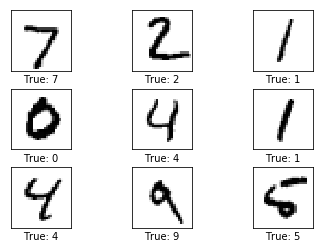

In [35]:
data.test.cls=np.array([label.argmax() for label in data.test.labels])


images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

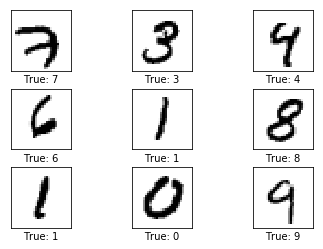

In [36]:
data.train.cls=np.array([label.argmax() for label in data.train.labels])
images=data.train.images[0:9]
cls_true=data.train.cls[0:9]
plot_images(images=images,cls_true=cls_true)

## Computation Graph

In [37]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true=tf.placeholder(tf.float32,[None, num_classes])
y_true_cls=tf.placeholder(tf.int64, [None])

In [38]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.add(tf.matmul(x, weights),biases)
y_pred=tf.nn.softmax(logits)
y_pred_cls=tf.argmax(y_pred,axis=1)

In [39]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [40]:
correct_prediction=tf.equal(y_pred_cls,y_true_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TF Run Session

## Train Time

In [41]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [42]:
batch_size = 128


def optimize(num_iterations):
    for i in range(num_iterations):

        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

## Test Time

In [55]:
feed_dict_test={x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

def print_test_accuracy():
    acc = session.run(accuracy, feed_dict={x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls})
    print("Accuracy on test-set: {0:.1%}".format(acc))
    


In [44]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [45]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
    


In [46]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Execute.....

Accuracy on test-set: 9.8%


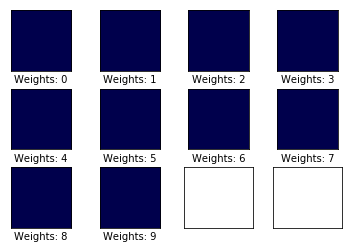

In [47]:
print_test_accuracy()
plot_weights()

Accuracy on test-set: 77.7%


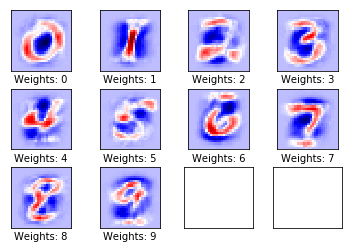

In [48]:
optimize(10)
print_test_accuracy()
plot_weights()

The weights in the red color are positive that is higher weight values while the dark blue is negatvie weights. 


The weights can also be plotted as shown below. Positive weights are red and negative weights are blue. These weights can be intuitively understood as image-filters.

For example, the weights used to determine if an image shows a zero-digit have a positive reaction (red) to an image of a circle, and have a negative reaction (blue) to images with content in the centre of the circle.

Similarly, the weights used to determine if an image shows a one-digit react positively (red) to a vertical line in the centre of the image, and react negatively (blue) to images with content surrounding that line.

Note that the weights mostly look like the digits they're supposed to recognize. This is because only one optimization iteration has been performed so the weights are only trained on 100 images. After training on several thousand images, the weights become more difficult to interpret because they have to recognize many variations of how digits can be written.


Accuracy on test-set: 88.4%


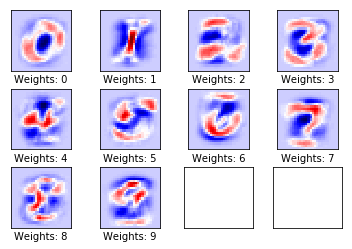

In [49]:
optimize(50)
print_test_accuracy()
plot_weights()

Accuracy on test-set: 89.8%


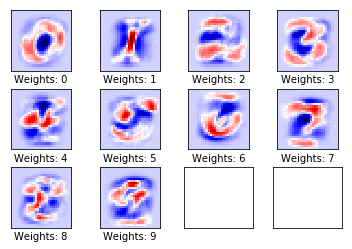

In [50]:
optimize(50)
print_test_accuracy()
plot_weights()

Accuracy on test-set: 92.1%


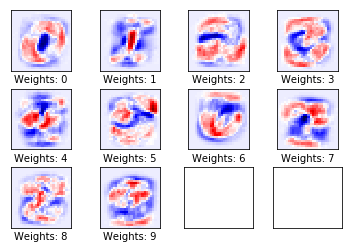

In [51]:
optimize(1000)
print_test_accuracy()
plot_weights()

Accuracy on test-set: 92.4%


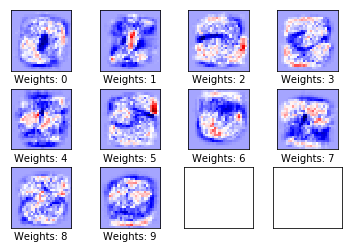

In [52]:
optimize(5000)
print_test_accuracy()
plot_weights()

Accuracy on test-set: 92.4%


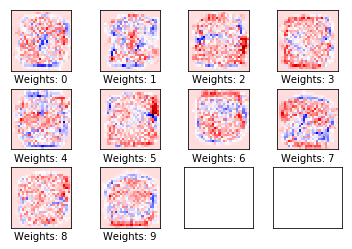

In [53]:
optimize(50000)
print_test_accuracy()
plot_weights()

[[ 956    0    0    3    1   12    4    3    1    0]
 [   0 1111    3    2    0    2    3    2   12    0]
 [   5    9  925   16    9    5   14   13   33    3]
 [   4    1   18  911    0   36    3   10   16   11]
 [   1    3    7    3  913    0    6    7    6   36]
 [  10    2    3   33    8  789   11    6   25    5]
 [   7    3    7    3    7   22  905    2    2    0]
 [   2    7   18    8    5    1    0  957    2   28]
 [   9   10    7   23    7   37   10   14  841   16]
 [   9    6    0   10   20    8    0   23    6  927]]


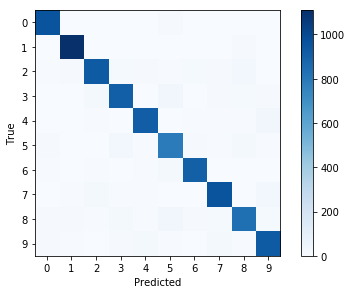

In [56]:
print_confusion_matrix()